# Predicting GDP growth : A linear regression and LASSO regression tutorial

## Setup

The library `missingno` requires a package called `distutils` which has been deprecated and removed as of Python 3.12. 
To circumvent this problem:
- you need to first install the `setuptools` library with:
`pip -U setuptools`. 
- Then you need to upgrade `pip` with `pip install --upgrade pip`
- and finally you run `pip install --upgrade seaborn missingno`

By doing this, you ensure to not only install the `missingno` package but also install/upgrade its dependencies to the right versions!

Technically, the `miceforest` package (used for imputation) is available via `conda` but it's an older version than with `pip` so we'll use `pip install -U miceforest` this time.

To run this notebook, you'll also need to install the `wbdata` package (see [documentation](https://wbdata.readthedocs.io/en/stable/)), which is a convenient Python wrapper around the World Bank Bank's publicly available data resources. To install this package, use the `pip install -U wbdata` command

Other packages you will need include:
- `pandas`
- `numpy`
- `statsmodels`
- `scikit-learn` (imported as variations of `sklearn`)
- `lets-plot` (imported as `lets_plot`)

In [29]:
import wbdata
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import datetime
import missingno as msno
import miceforest as mf
from sklearn.model_selection import train_test_split
from lets_plot import *
LetsPlot.setup_html()

## Data loading and preparation

We define the set of indicators we'll use for our analysis in this notebook: 

- central government debt expressed as a percentage of GDP, otherwise known as debt-to-GDP ratio ( debt-to-GDP ratio measures a country’s debt burden in relation to its economic output)
- estimate of government effectiveness (this measure reflects the perception of the quality of public services and the government’s credibility)
- annual percentage of consumer price inflation (this is one of the factors that is widely recognized as impacting economic growth)
- government expenditure on education expressed as percentage of GDP (this is yet another one of the factors that is widely recognized as impacting economic growth)
- Industrial Production, in constant US $ seasonally adjusted (this is a proxy for industrial activity which is associated with economic growth)
- annual percentage of GDP growth (this will be our prediction target)

In [3]:

indicators = {
    'GC.DOD.TOTL.GD.ZS': 'debt_gdp_ratio', # Central government debt, total (% of GDP)
    'GE.EST': 'gov_effectiveness', # Government Effectiveness: Estimate
    'FP.CPI.TOTL.ZG': 'inflation', # Inflation, consumer prices (annual %)
    'SE.XPD.TOTL.GD.ZS': 'public_investment', # Government expenditure on education, total (% of GDP)
    'IPTOTSAKD': 'industrial_output', #'Industrial Production, constant US$, seas. adj.'
    'NY.GDP.MKTP.KD.ZG': 'gdp_growth' # GDP growth (annual %)
} 

We segregate countries into categories (as defined by the World Bank):

- low income countries
- lower middle income countries
- upper middle income countries
- high income countries

For details on these classifications, see [here](https://blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025)

In [4]:
hic_countries = {i['id']:i['name'] for i in wbdata.get_countries(incomelevel='HIC')} # dictionary of high income countries
umc_countries = {i['id']:i['name'] for i in wbdata.get_countries(incomelevel='UMC')} # dictionary of upper middle income countries
lmc_countries = {i['id']:i['name'] for i in wbdata.get_countries(incomelevel='LMC')} # dictionary of lower middle income countries
lic_countries = {i['id']:i['name'] for i in wbdata.get_countries(incomelevel='LIC')} # dictionary of low income countries

We'll look at data from 2022, which is a year particularly marked by its worldwide inflation surge.

In [5]:
data_date = datetime.datetime(2022, 1, 1), datetime.datetime(2022, 12, 31)

Now, let's get the data.

In [6]:
df_hic = wbdata.get_dataframe(indicators, country=hic_countries, date=data_date , parse_dates=True)
df_umc = wbdata.get_dataframe(indicators, country=umc_countries, date=data_date , parse_dates=True)
df_lic = wbdata.get_dataframe(indicators, country=lic_countries, date=data_date , parse_dates=True)
df_lmc = wbdata.get_dataframe(indicators, country=lmc_countries, date=data_date , parse_dates=True)

Let's view the data for low income countries.

In [7]:
df_lic

debt_gdp_ratio  gov_effectiveness   inflation  \
country                                                                    
Afghanistan                           NaN          -1.880035         NaN   
Burkina Faso                    62.525612          -0.853149   14.290235   
Burundi                               NaN          -1.263606   18.800879   
Central African Republic              NaN          -1.710303    5.583167   
Chad                                  NaN          -1.423674    5.788027   
Congo Dem. Rep.                       NaN                NaN         NaN   
Congo, Dem. Rep.                15.989697          -1.746675         NaN   
Eritrea                               NaN          -1.731298         NaN   
Ethiopia                              NaN          -0.791824   33.889880   
Gambia The                            NaN                NaN         NaN   
Gambia, The                           NaN          -0.653573   11.513120   
Guinea-Bissau                         NaN          -1.486933    9.393839   
Korea, Dem. People's Rep.             NaN          -1.463778         NaN   
Liberia                               NaN          -1.431080    7.592985   
Madagascar                            NaN          -0.972033    8.160590   
Malawi                          55.599212          -0.853226   20.953970   
Mali                                  NaN          -1.148953    9.621476   
Mozambique                      76.635061          -0.737049   10.279402   
Niger                                 NaN          -0.627598    4.226218   
Rwanda                                NaN           0.232074   17.689210   
Sierra Leone                          NaN          -1.170131   27.208288   
Somalia                               NaN          -2.027404         NaN   
South Sudan                           NaN          -2.390764   -6.687321   
Sudan                                 NaN          -1.686378  138.808460   
Syrian Arab Republic                  NaN          -1.753014         NaN   
Togo                                  NaN          -0.645623    7.967574   
Uganda                          53.890283          -0.605069    7.195789   
Yemen Rep.                            NaN                NaN         NaN   
Yemen, Rep.                           NaN          -2.233465         NaN   

                           public_investment  industrial_output  gdp_growth  
country                                                                      
Afghanistan                              NaN                NaN   -6.240172  
Burkina Faso                        5.276512                NaN    1.497240  
Burundi                             4.821047                NaN    1.848999  
Central African Republic            2.115091                NaN    0.502110  
Chad                                2.538673                NaN    2.804341  
Congo Dem. Rep.                          NaN                NaN         NaN  
Congo, Dem. Rep.                    3.002521                NaN    8.924448  
Eritrea                                  NaN                NaN         NaN  
Ethiopia                            3.736495                NaN    5.321176  
Gambia The                               NaN                NaN         NaN  
Gambia, The                         2.742823                NaN    5.492998  
Guinea-Bissau                            NaN                NaN    4.605832  
Korea, Dem. People's Rep.                NaN                NaN         NaN  
Liberia                             2.276096                NaN    4.808105  
Madagascar                          3.139020                NaN    4.000000  
Malawi                                   NaN                NaN    0.921115  
Mali                                4.035055                NaN    3.474952  
Mozambique                          6.161984       3.995988e+09    4.364451  
Niger                               4.101431                NaN   11.900000  
Rwanda                          

In [8]:
df_hic

debt_gdp_ratio  gov_effectiveness  inflation  \
country                                                               
American Samoa                    NaN           0.667629        NaN   
Andorra                           NaN           1.495261        NaN   
Antigua and Barbuda               NaN          -0.160003   7.531078   
Aruba                             NaN           1.105213        NaN   
Australia                   58.046696           1.528433   6.594097   
...                               ...                ...        ...   
United Arab Emirates              NaN           1.299128   5.291226   
United Kingdom             141.244397           1.238090   7.922049   
United States              112.889633           1.255496   8.002800   
Uruguay                           NaN           0.849588   9.104380   
Virgin Islands (U.S.)             NaN           0.667629        NaN   

                       public_investment  industrial_output  gdp_growth  
country                                                                  
American Samoa                       NaN                NaN    1.735016  
Andorra                         2.647290                NaN    9.564612  
Antigua and Barbuda             3.647748                NaN    9.516396  
Aruba                                NaN                NaN    8.517918  
Australia                       5.206777                NaN    4.242386  
...                                  ...                ...         ...  
United Arab Emirates                 NaN                NaN    7.509697  
United Kingdom                  4.959176       4.827621e+11    4.839085  
United States                        NaN       3.346608e+12    2.512375  
Uruguay                         4.507330       1.317742e+10    4.707258  
Virgin Islands (U.S.)                NaN                NaN   -1.311232  

[92 rows x 6 columns]

The first thing we notice is that we have plenty of missing values in our data. Let's explore that further.

### Exploring missing values

**Detecting missing values numerically**

We first try and compute the count/percentage of missing values in every column of the dataset. This gives an idea about the distribution of missing values.


In [17]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction.
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
print('Here is the table for high income countries\n')
missing_values_table(df_hic)

Here is the table for high income countries

Your selected dataframe has 6 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
debt_gdp_ratio                 66               71.7
public_investment              52               56.5
industrial_output              51               55.4
inflation                      34               37.0
gov_effectiveness              19               20.7
gdp_growth                     13               14.1

In [19]:
print('Here is the table for low income countries\n')
missing_values_table(df_lic)

Here is the table for low income countries

Your selected dataframe has 6 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
industrial_output              27               93.1
debt_gdp_ratio                 24               82.8
public_investment              13               44.8
inflation                      10               34.5
gdp_growth                      7               24.1
gov_effectiveness               3               10.3

In [72]:
print('Here is the table for upper middle income countries\n')
missing_values_table(df_umc)

Here is the table for upper middle income countries

Your selected dataframe has 6 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
debt_gdp_ratio                 35               61.4
industrial_output              32               56.1
public_investment              14               24.6
inflation                       9               15.8
gov_effectiveness               3                5.3
gdp_growth                      3                5.3

In [73]:
print('Here is the table for low middle income countries\n')
missing_values_table(df_lmc)

Here is the table for low middle income countries

Your selected dataframe has 6 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
debt_gdp_ratio                 48               84.2
industrial_output              42               73.7
public_investment              12               21.1
inflation                       8               14.0
gov_effectiveness               6               10.5
gdp_growth                      6               10.5

**Detecting missing data visually using `Missingno` library**

  To graphically/visually analyse the missingness in the data, we use a library called `Missingno`: it is a package for the graphical analysis of missing values. To use this library, we need to import it as follows: `import missingno as msno` (see library import step above).

<Axes: >

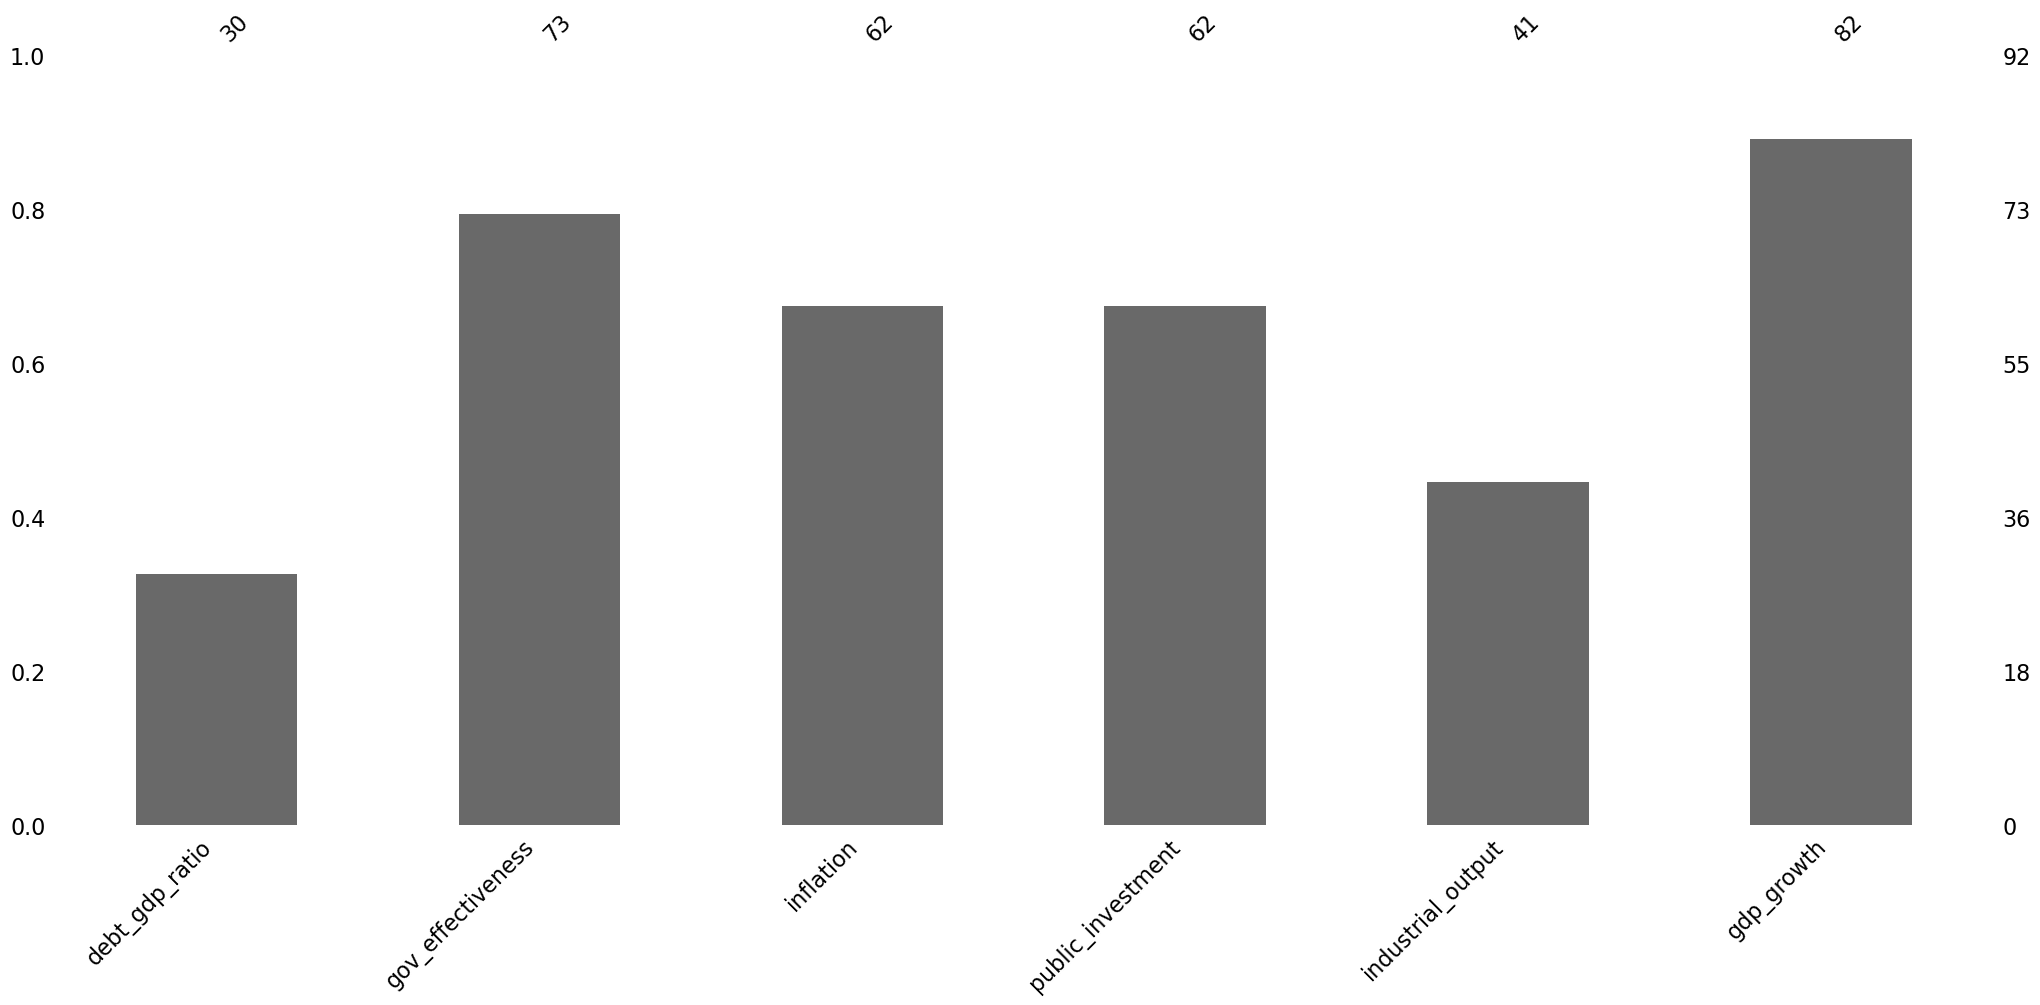

In [36]:
msno.bar(df_hic)

The bar chart above gives a quick graphical overview of the completeness of the dataset. We can see that all variables have some amount of missing values but that the `debt_gdp_ratio`, and `industrial_output` columns in particular, have very large proportions of missing values (more than 60% and above 55% respectively)). Next, it would make sense to try and find out the locations of the missing data.

**Visualizing the locations of the missing data**

  The `msno.matrix` nullity matrix is a data-dense display which allows the user to quickly visually pick out patterns in data completeness.

  The plot appears blank/white where there are missing values. 

  The sparkline on the right gives an idea of the general shape of the completeness of the data and points out the row with the minimum nullities and the total number of columns in a given dataset, at the bottom.

<Axes: >

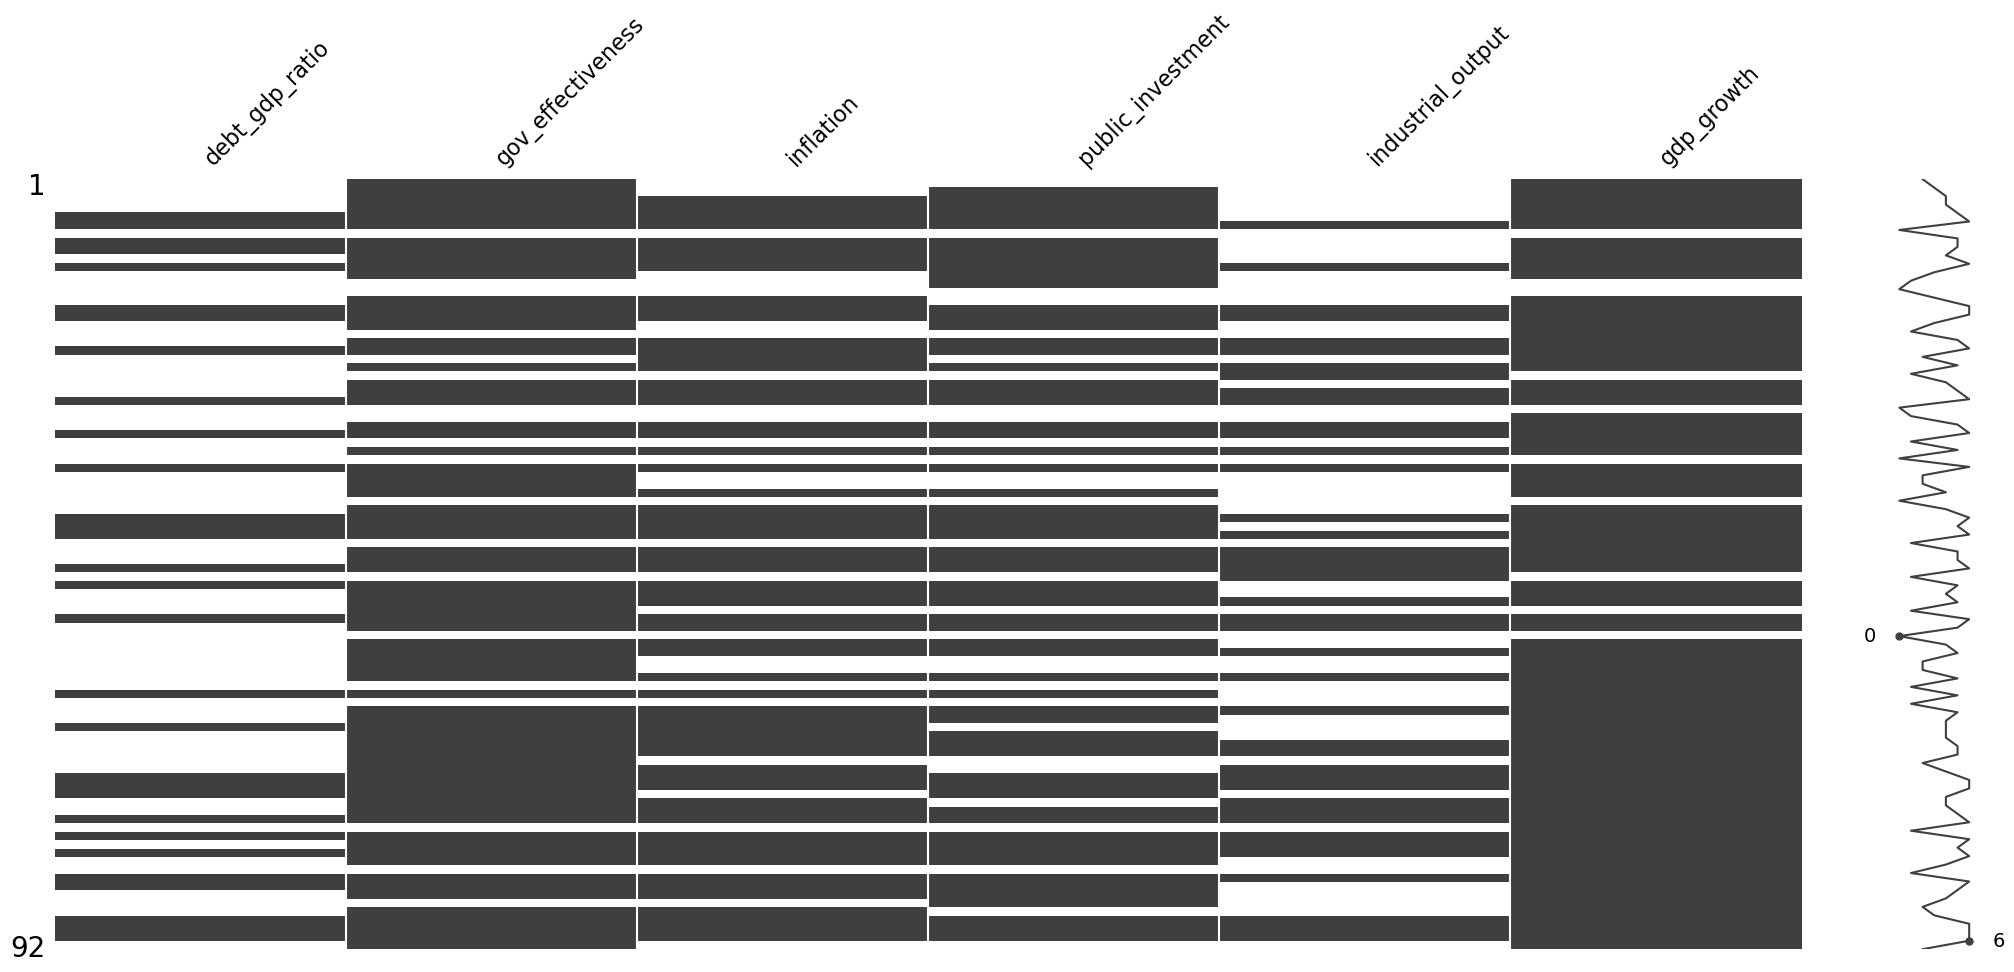

In [37]:
msno.matrix(df_hic)

**Reasons for Missing Values**

Before we start handling the missing values, it is important to understand the various reasons behind the missingness in the data. Broadly speaking, there can be three possible reasons (also called (data) missingness mechanisms):

  1. Missing Completely at Random (MCAR)

  The missing values on a given random variable (Y) are not associated/correlated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

  2. Missing at Random (MAR)

  The MAR mechanism occurs when the probability of missing values for a given random variable Y is related to some other measured variable (or variables) in the analysis model but not to the the values of Y itself.

  3. Missing Not at Random (MNAR)

  Missingness depends on variables unobserved in the data available or on the value of the random variable Y (which is missing values) itself.

  For more details, see Enders, Craig K. *Applied missing data analysis*. Guilford Publications, 2022. or Scheffer, Judi. *Dealing with missing data.* (2002).

  Now let us look at nullity matrix again to see if can find what type of missingness is present in the dataset.

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another

<Axes: >

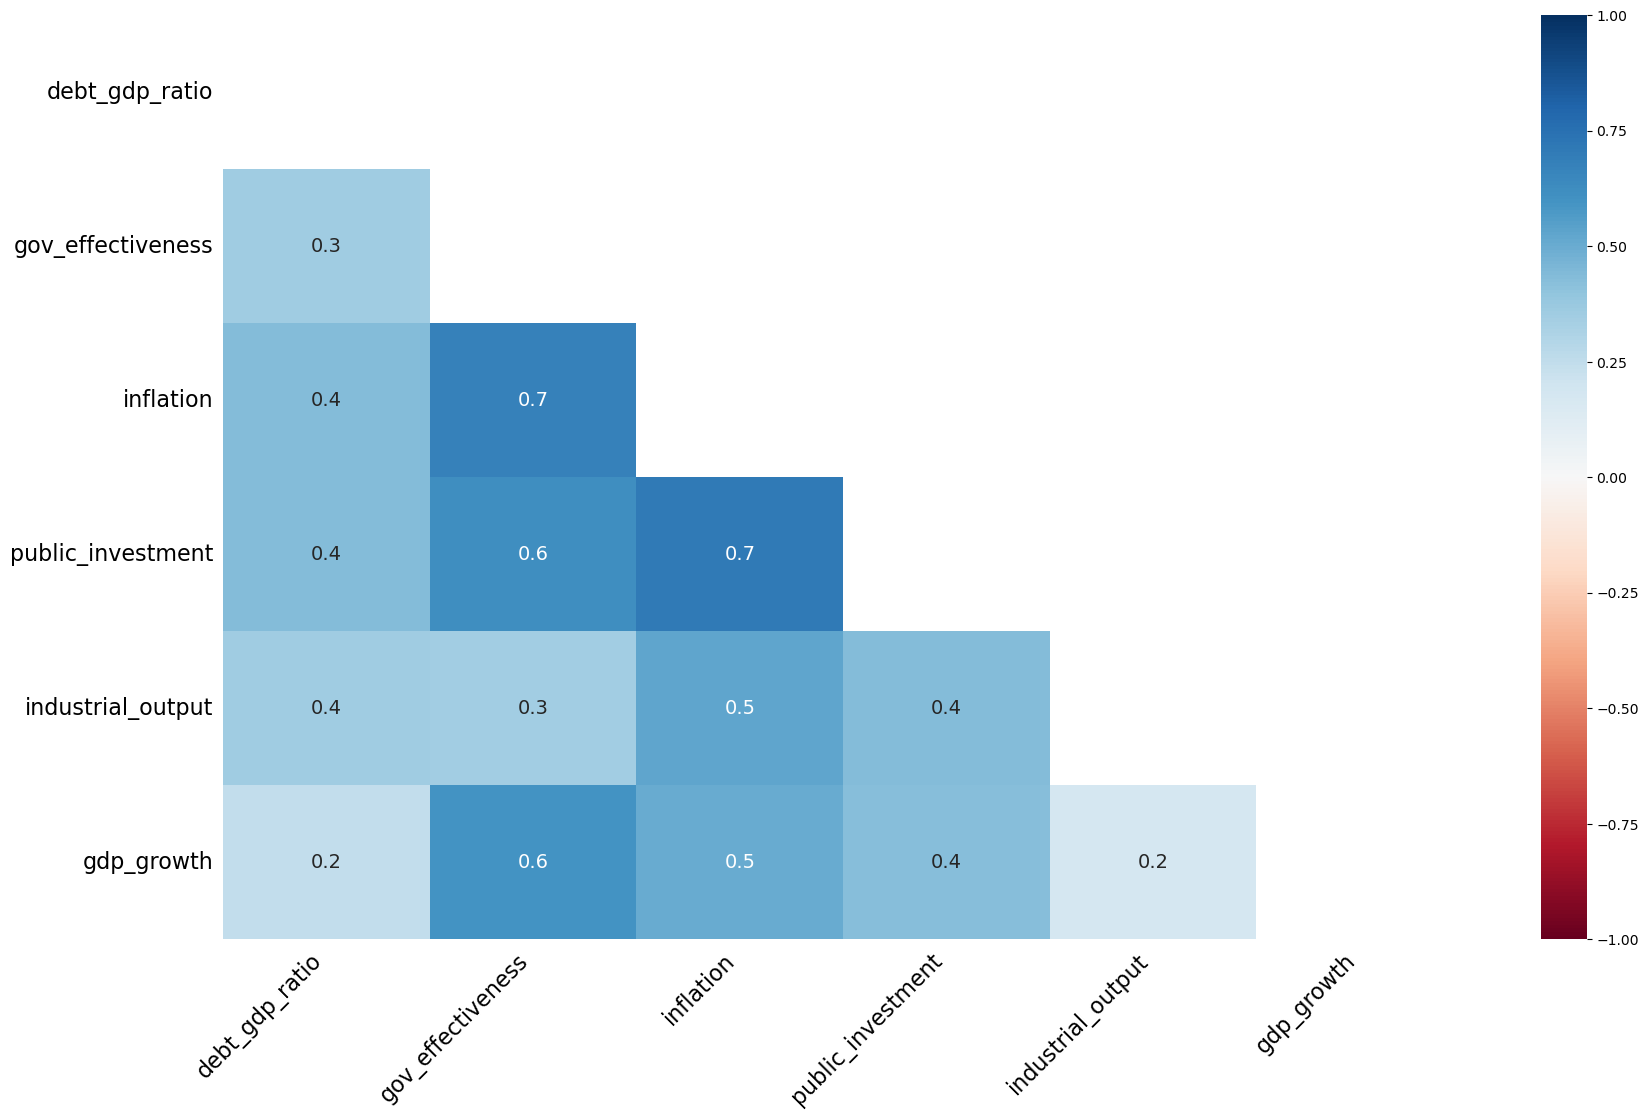

In [38]:
msno.heatmap(df_hic)

We could have seen this from the nullity matrix but the heatmap confirms this: the missingness patterns for `inflation` and `public_investment` are rather strongly correlated. The same can be said for `inflation` and `government_effectiveness`. All in all, we seem to have at least a MAR type of pattern. So dropping missing values is not a valid strategy: we need something more robust.

The same patterns observed for high income countries repeat for other groups of countries, with the difference that the level of missingness of `debt_gdp_ratio` and `industrial_output` are even higher.

<Axes: >

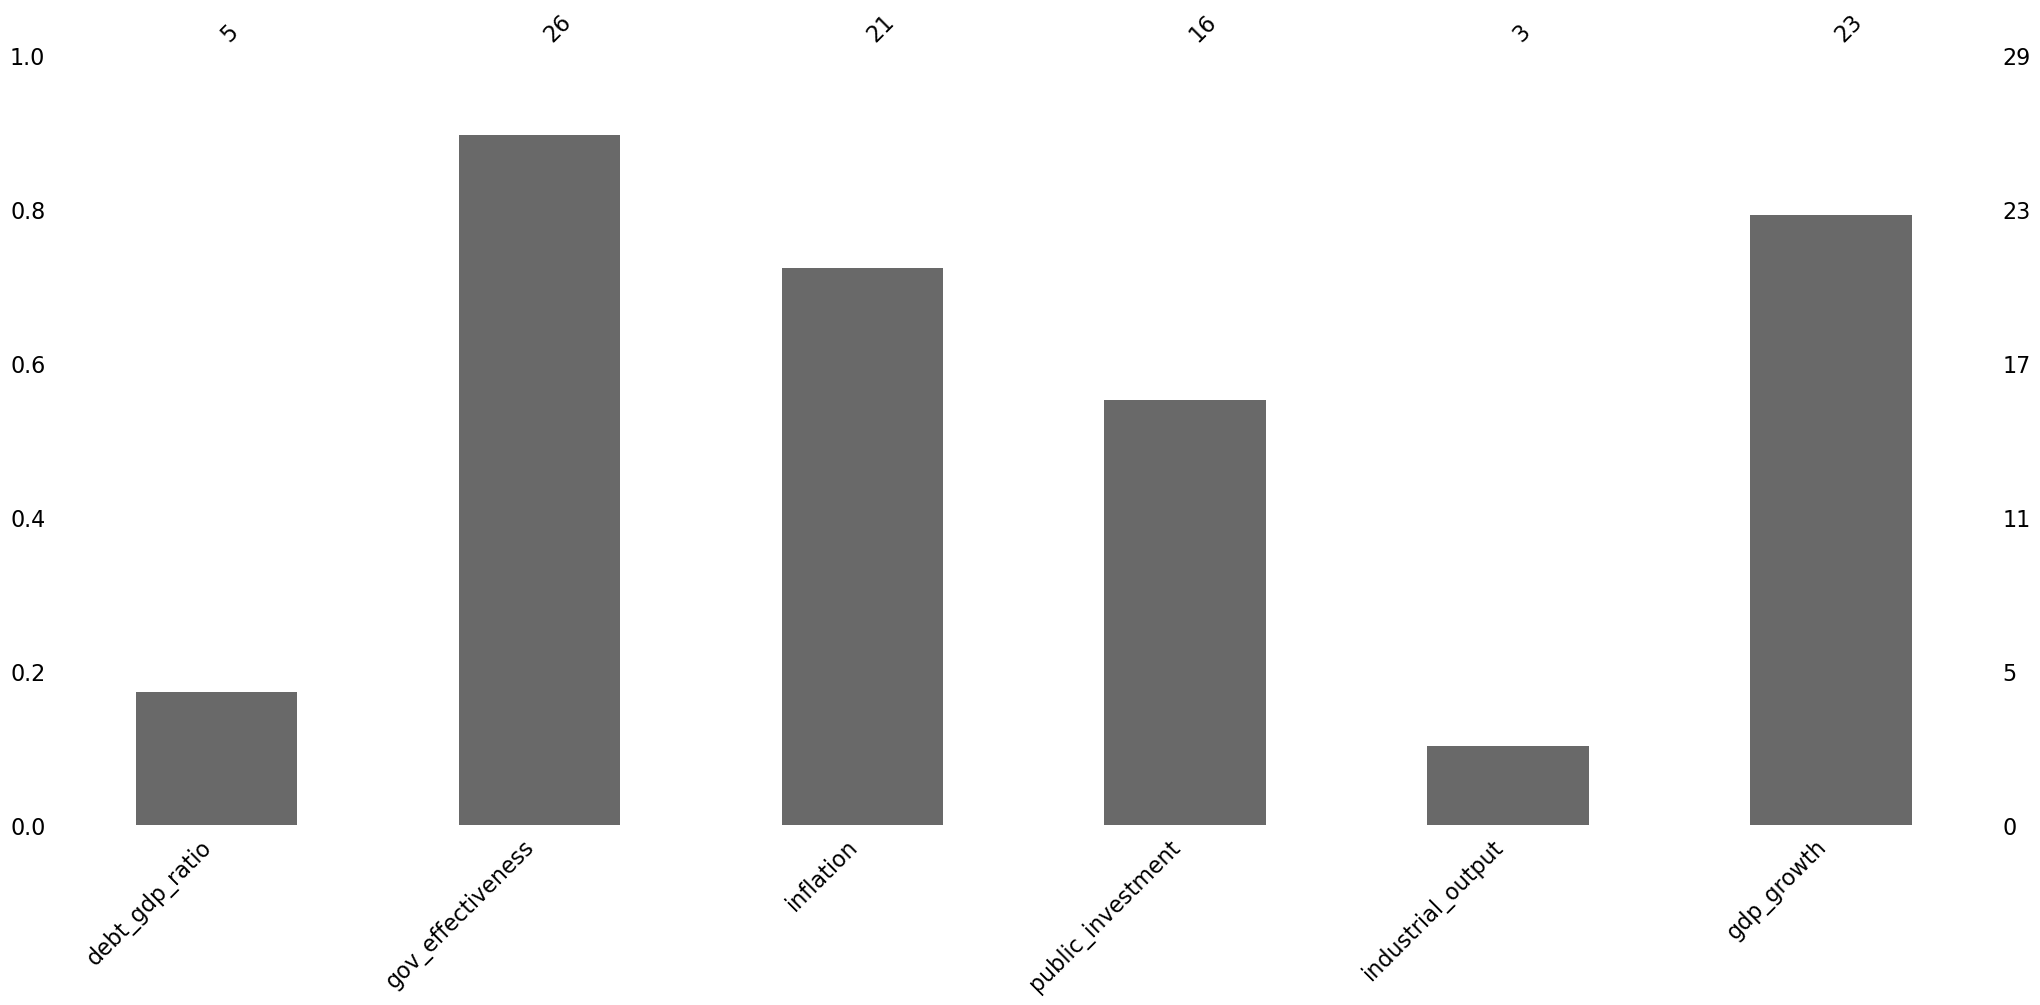

In [39]:
msno.bar(df_lic)

<Axes: >

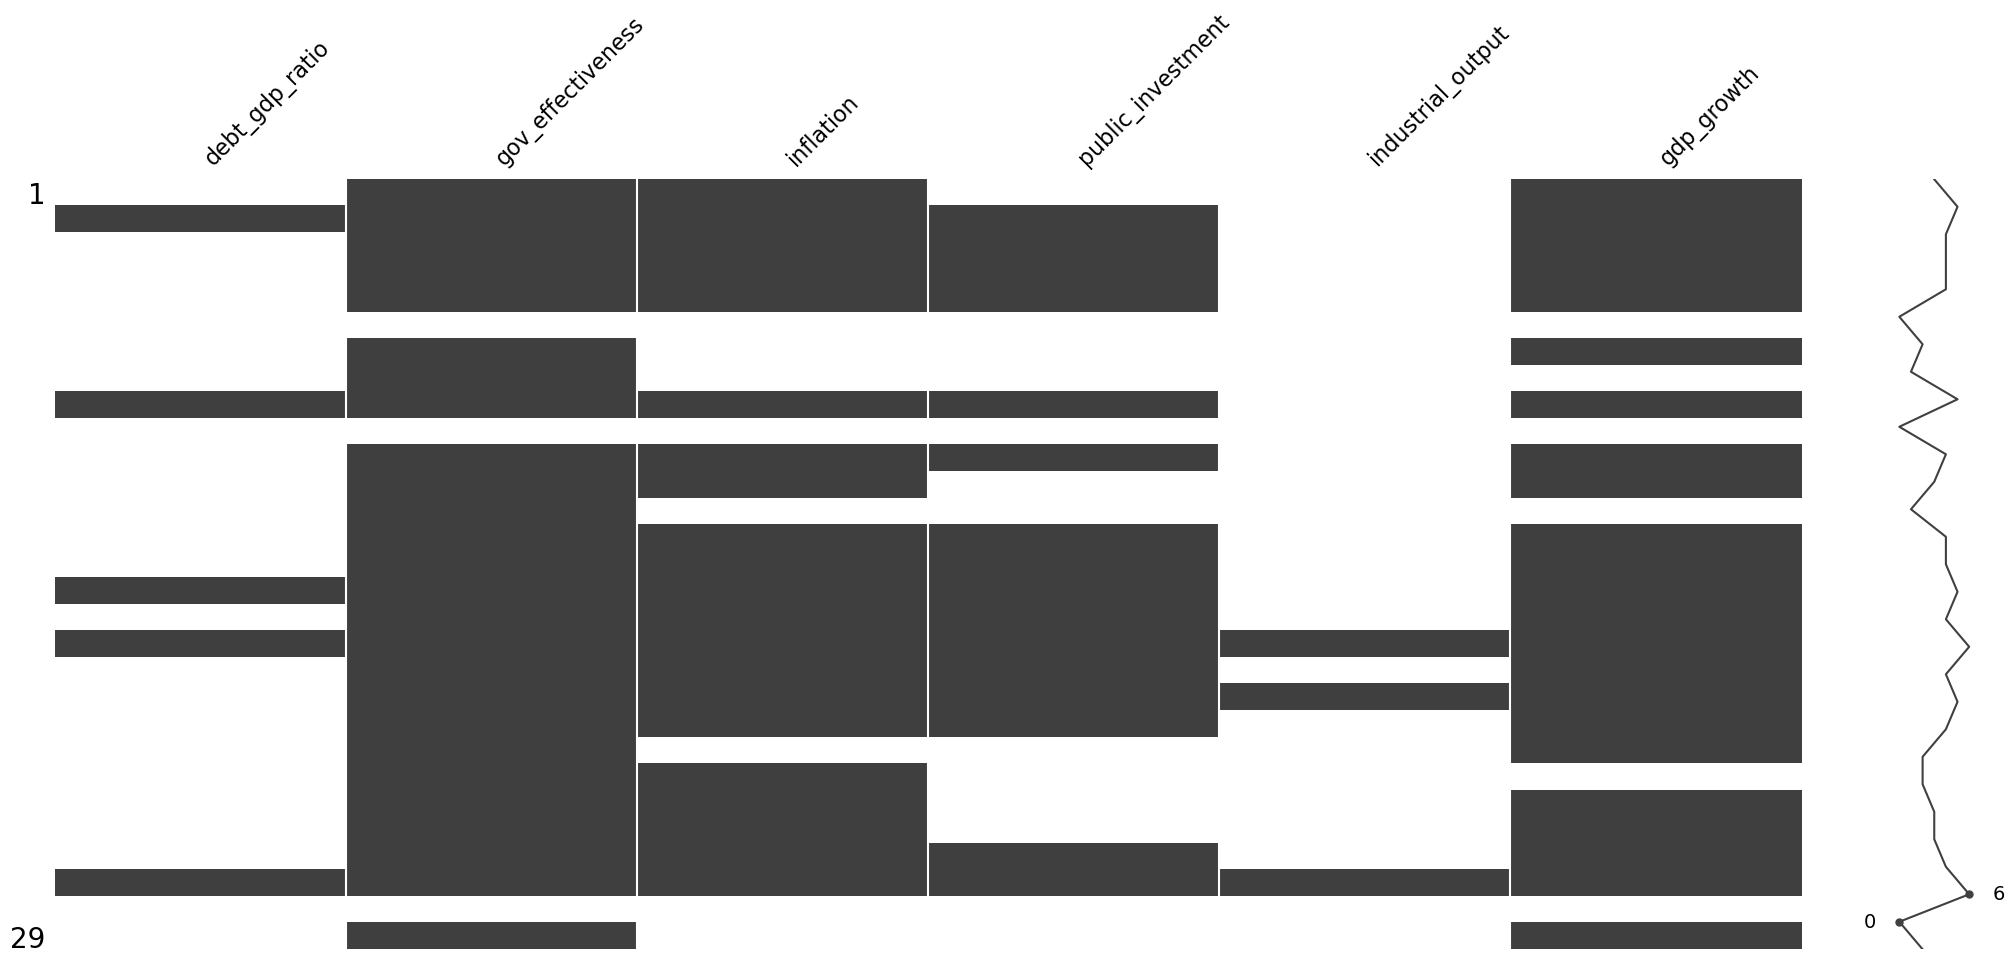

In [40]:
msno.matrix(df_lic)

<Axes: >

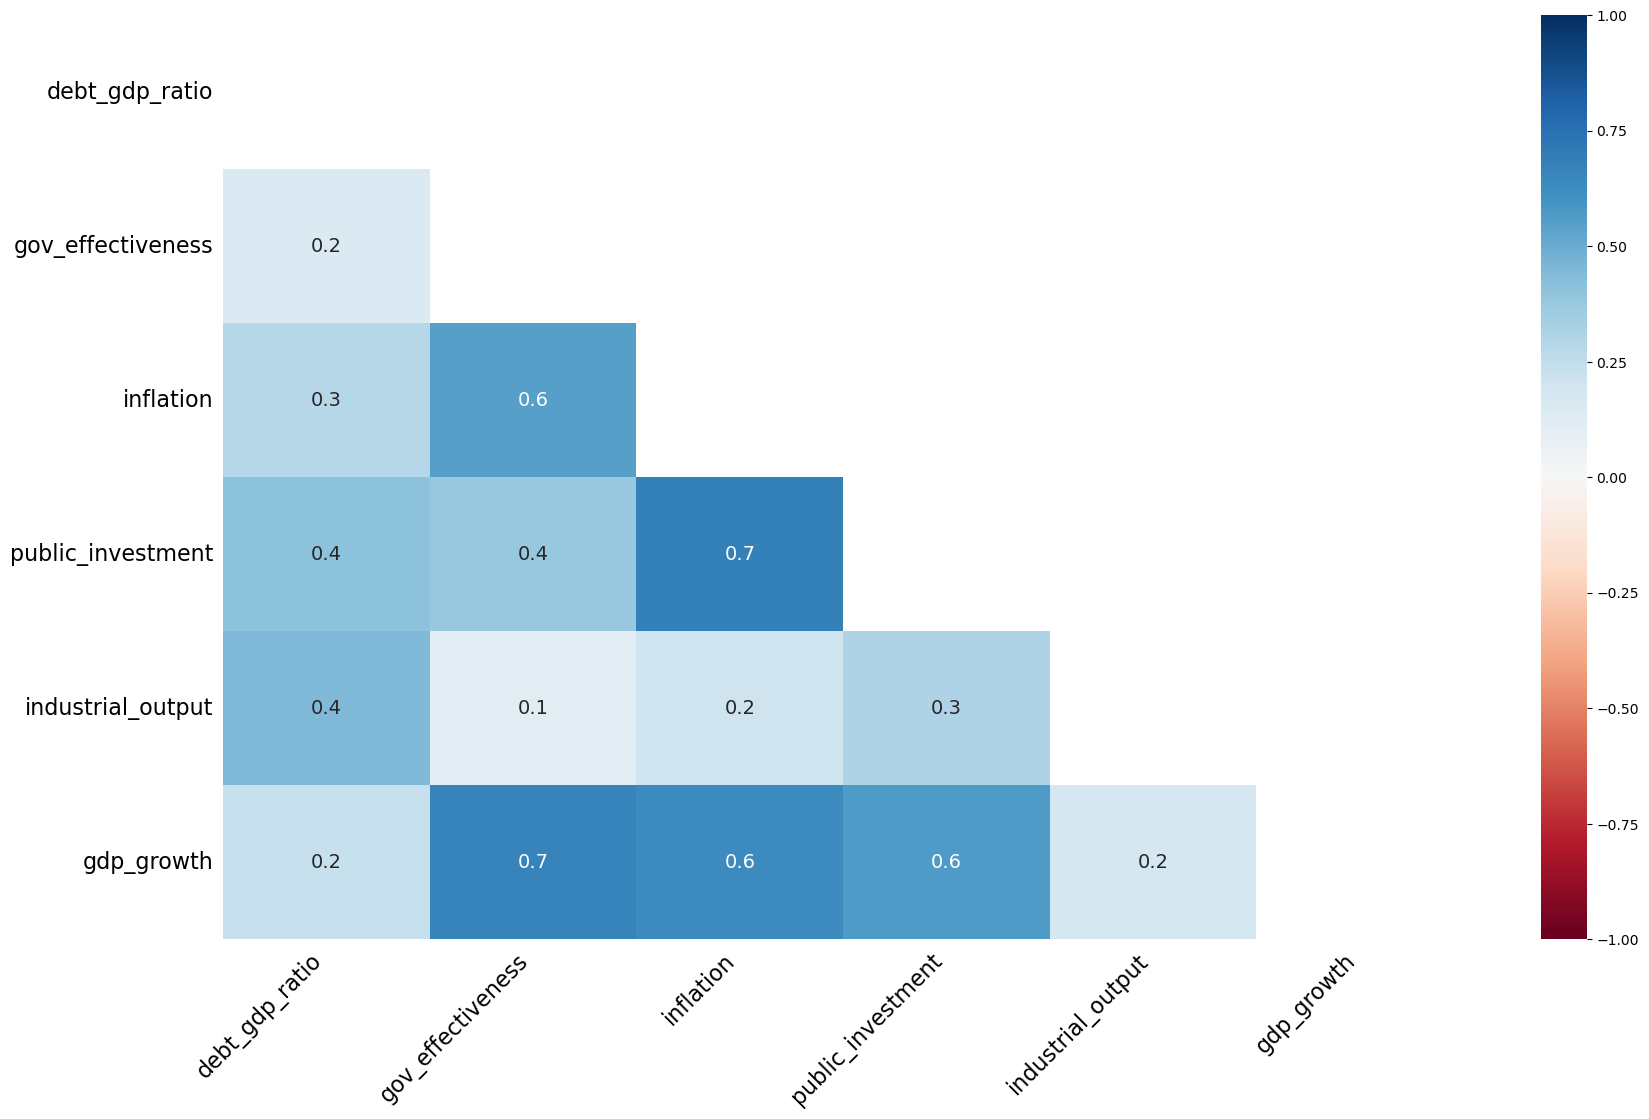

In [41]:
msno.heatmap(df_lic)

<Axes: >

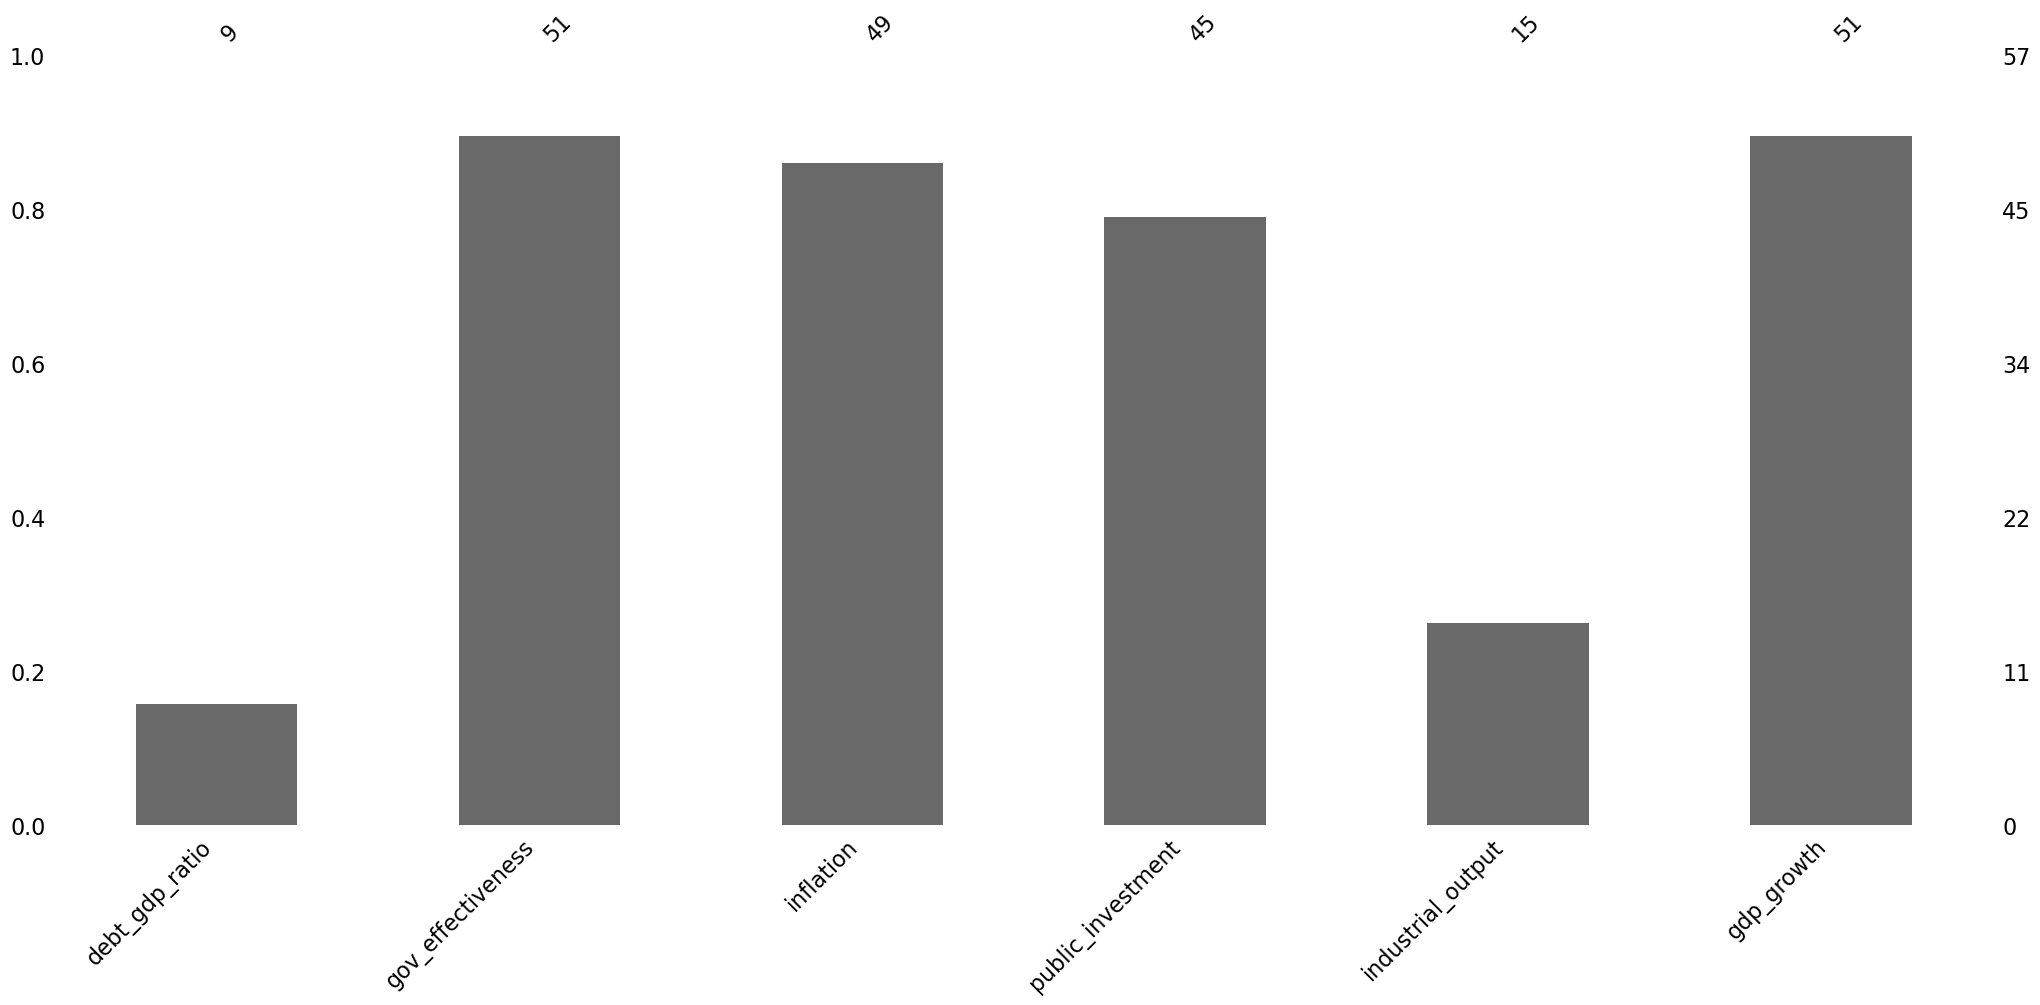

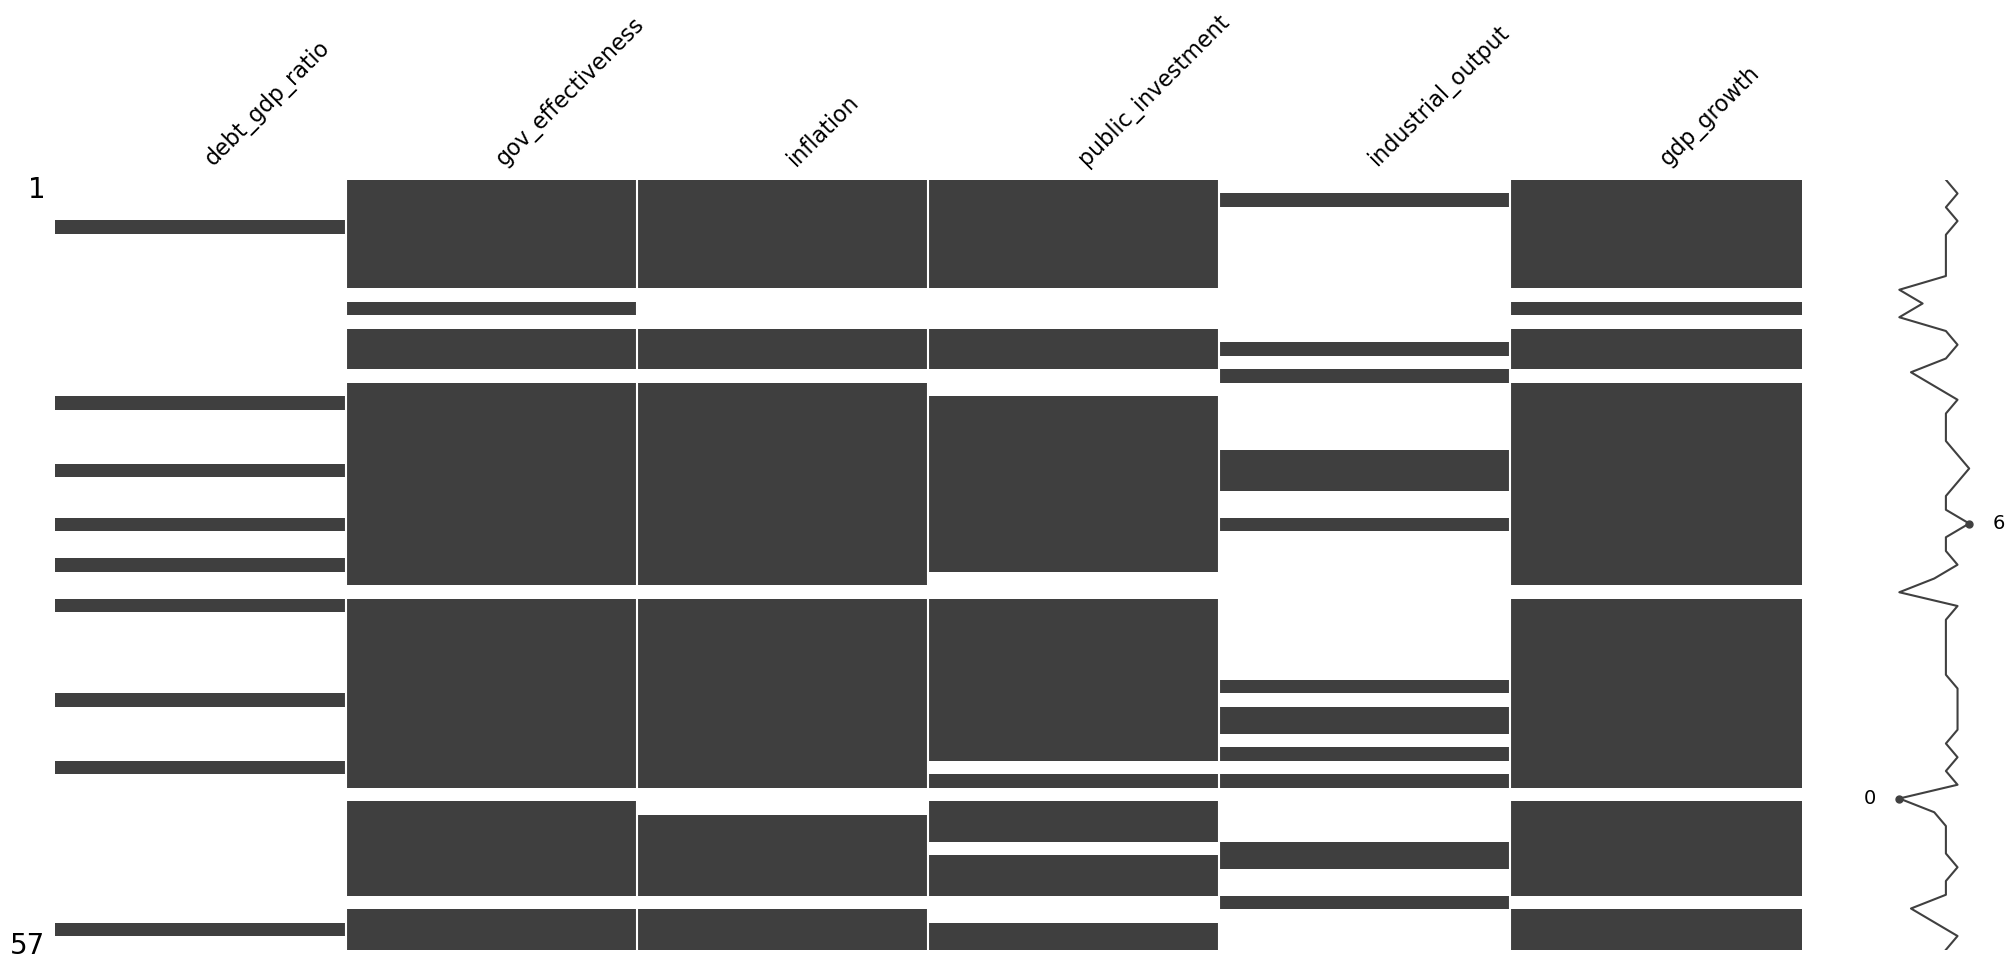

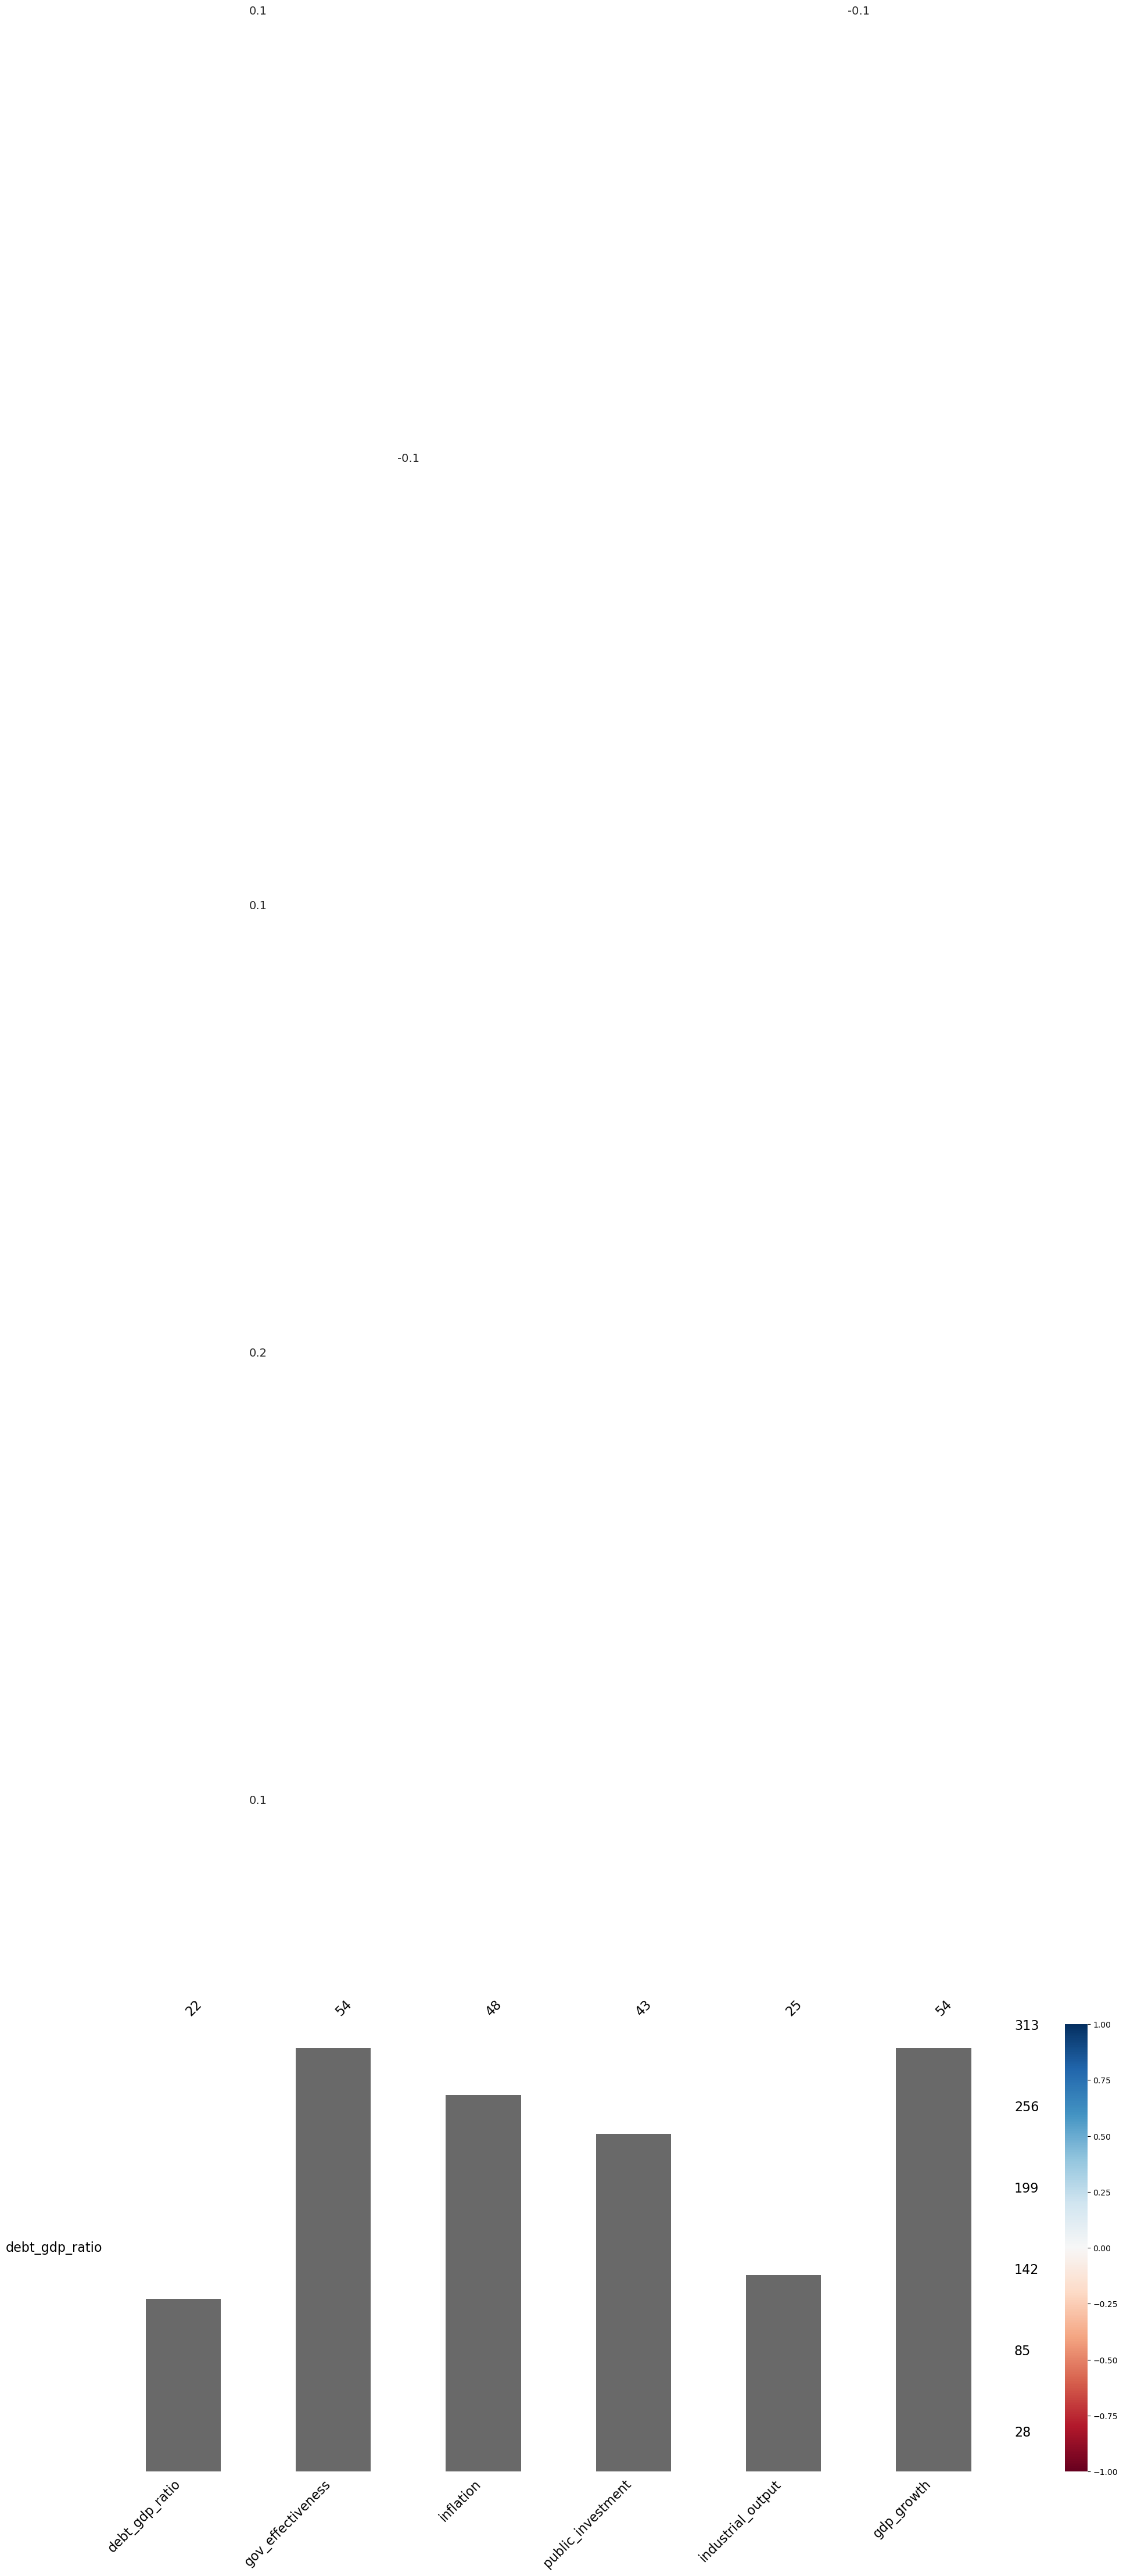

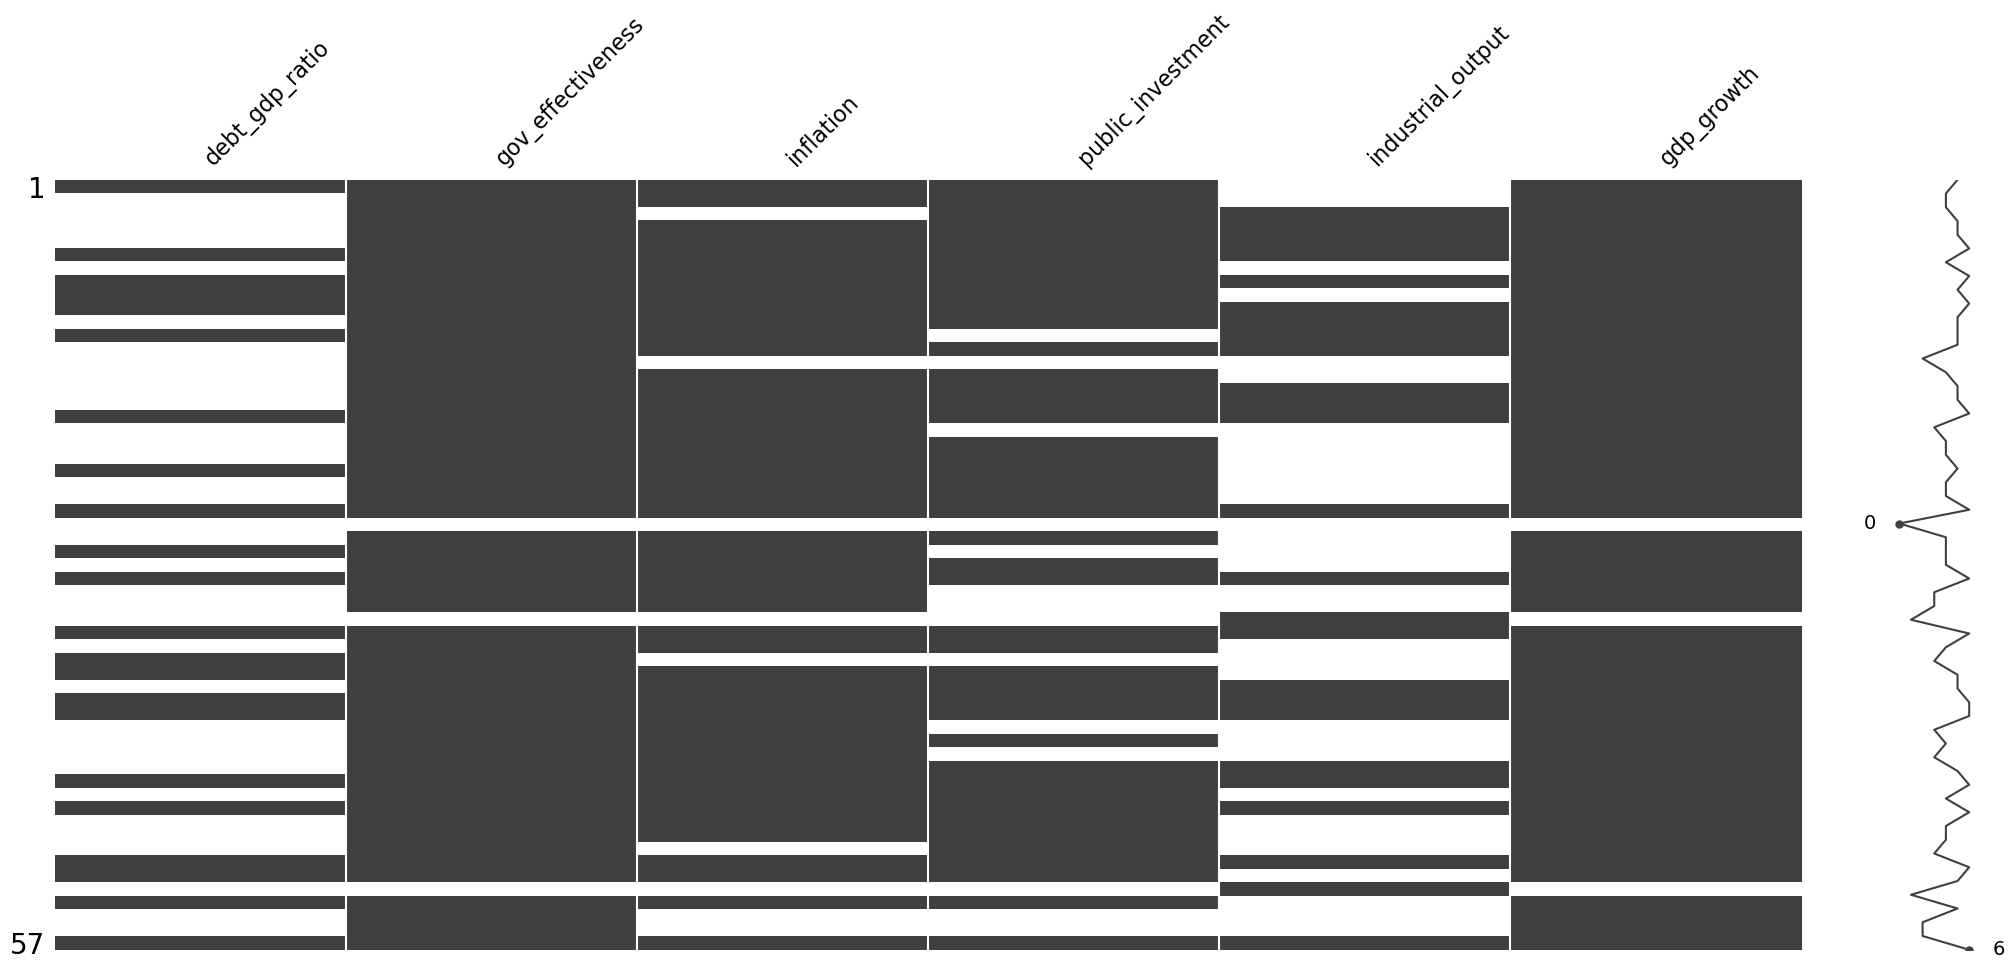

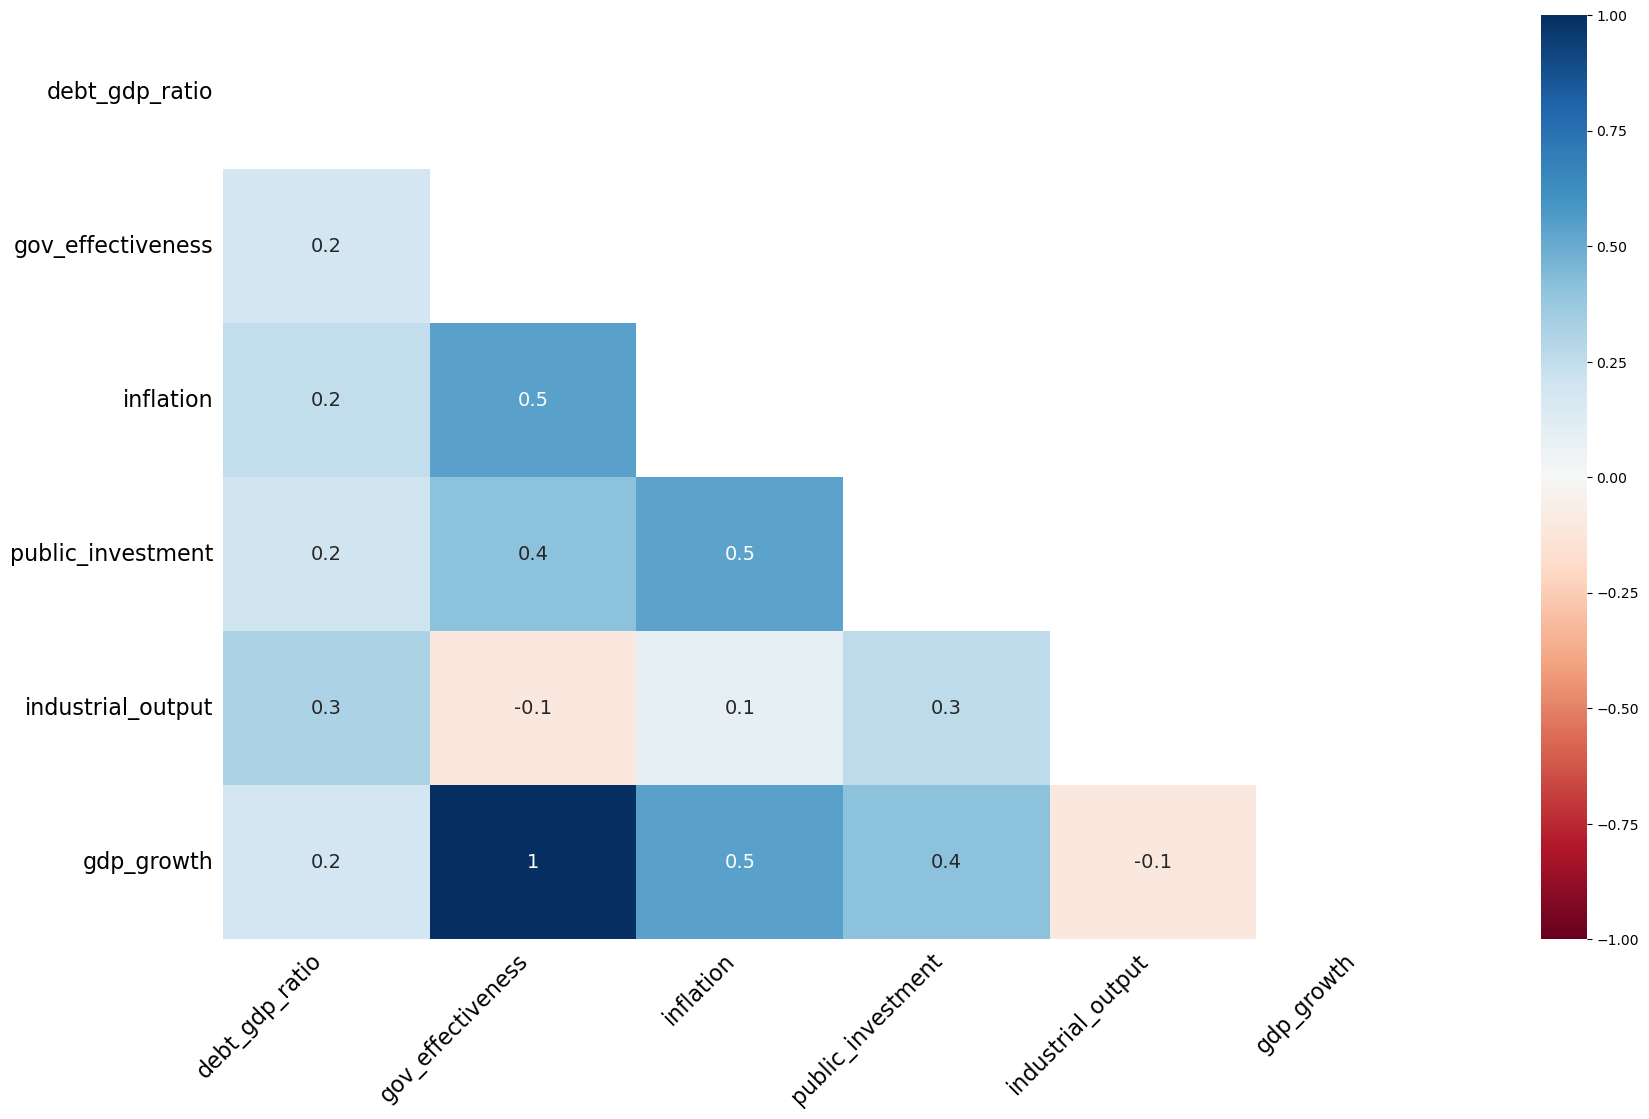

In [42]:
msno.bar(df_lmc)
msno.matrix(df_lmc)
msno.heatmap(df_lmc)
msno.bar(df_umc)
msno.matrix(df_umc)
msno.heatmap(df_umc)

## Linear regression:  Predicting growth in high income countries

### Training/test split

Before I deal with my missing values (i.e impute my missing values, in other words try and estimate them based on other existing values in the data), there is one step that I need to take. I need to split my data in what we call a training and test set.

What are a training and a test set?

- A **training set** is data that we use to build (or "train") a model. In the case of linear regression, we are using the training data to estimate a series of coefficients. 
- A **test set** is data that the model has not seen yet and that we use to find out how good our model is at predicting and how well its predictions generalize to data it hasn't encountered before 
  
  e.g our task is to predict quarterly GDP for a certain country, say the UK, we would for example train the model on past available data (e.g from Q1 1955 to Q1 2021) (GDP data from Q1 1955 to Q1 2021 is our **training set**) and test it on, say, data from Q2 2021 to Q3 2024 (this data would our **test set**)^[such data can usually be found on the website of the Office of national Statistics (ONS)].  

Why can't I do my imputation before splitting the data into training and test set?

While the **test set** is supposed to be drawn from a distribution that is relatively similar to that of the training set (otherwise our predictions would be way off!), it is considered to be independent from the **training set** and is not supposed to contain information from it. If we were to do imputation prior to the training and test split, we would effectively be using information from the training set to derive data in the test set: that's what we call data leakage. Our training and test would no longer be independent, and we would run the risk of our predictions on the test being overly optimistic (i.e higher than they should be) because of that extra information we've unwittingly added.

Now that's out of the way, let's split our data.

In [49]:
df_hic['gdp_growth']

country
American Samoa           2.671119
Andorra                  1.588765
Antigua and Barbuda      6.953186
Aruba                    2.397085
Australia                2.878470
                           ...   
United Arab Emirates     1.313914
United Kingdom           1.405190
United States            2.966505
Uruguay                  0.164778
Virgin Islands (U.S.)    1.878307
Name: gdp_growth, Length: 92, dtype: float64

In [10]:
x_hic_train, x_hic_test, y_hic_train, y_hic_test = train_test_split(df_hic.drop('gdp_growth', axis=1), df_hic['gdp_growth'], random_state = 42)

### Multiple imputation

Before I go on, I'll do my imputation. There are many ways to do imputation (see [here](https://medium.com/@sanjushusanth/missing-value-imputation-techniques-in-python-62aeab65a6a6) or [here](https://scikit-learn.org/stable/modules/impute.html)) and some of the imputation methods will start making more sense once we start learning more machine learning techniques in the next couple of weeks.
For now, I'll just mention that one of the most robust imputation techniques there is (and pretty much considered state-of-the-art for numeric data) is called multiple imputation. The rough idea is that it performs multiple regressions (something we'll start seeing in a moment) over random samples of the data, then takes the average of the multiple regression values and uses that value to impute the missing value.

Because of what we explained earlier, we'll run imputation on the training set and test set separately.

In [11]:
np.random.seed(42)

x_hic_train = x_hic_train.reset_index(drop=True)
y_hic_train = y_hic_train.reset_index(drop=True)

hic_train_imp = mf.ImputationKernel(
  pd.concat([x_hic_train,y_hic_train],axis=1),
  save_all_iterations_data=True,
  random_state=100
)
# Run the MICE algorithm for 5 iterations
hic_train_imp.mice(5)
# Return the completed dataset (for MICE)
hic_train_imp_mice = hic_train_imp.complete_data(dataset=0)

In [12]:
y_hic_train_imp=hic_train_imp_mice[['gdp_growth']]
x_hic_train_imp=hic_train_imp_mice.drop('gdp_growth', axis=1)

In [14]:
np.random.seed(42) 

x_hic_test = x_hic_test.reset_index(drop=True)
y_hic_test = y_hic_test.reset_index(drop=True)

hic_test_imp = mf.ImputationKernel(
  pd.concat([x_hic_test,y_hic_test],axis=1),
  save_all_iterations_data=True,
  random_state=100
)
# Run the MICE algorithm for 5 iterations
hic_test_imp.mice(5)
# Return the completed dataset (for MICE)
hic_test_imp_mice = hic_test_imp.complete_data(dataset=0)

In [15]:
y_hic_test_imp=hic_train_imp_mice[['gdp_growth']]
x_hic_test_imp=hic_train_imp_mice.drop('gdp_growth', axis=1)

In [18]:
print('Here is the table for high income countries (train set) after imputation\n')
missing_values_table(hic_train_imp_mice)

print('And here is the table for high income countries (test set) after imputation\n')
missing_values_table(hic_test_imp_mice)

Here is the table for high income countries (train set) after imputation

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.
And here is the table for high income countries (test set) after imputation

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

### Linear regression

Now, we're finally ready to do our regression(s).

Let's try a couple of models:

- model 1: GDP growth only predicted through government effectiveness
- model 2: GDP growth as a function of government effectiveness and public investment
- model 3: GDP predicted through all the variables we have

**Linear regression Model 1: GDP as a function of government effectiveness** 

In [19]:
# Create a model instance of a linear regression
linear_model = LinearRegression()

# Fit this instance to the training set
linear_model.fit(x_hic_train_imp[['gov_effectiveness']], y_hic_train_imp)

LinearRegression()

In [32]:
x_hic_train_imp

debt_gdp_ratio  gov_effectiveness  inflation  public_investment  \
0        98.053313           1.165212   5.222367           2.647290   
1        74.918867           1.562987   6.153756           4.180441   
2        98.053313           1.219384   6.121060           1.922213   
3        98.053313          -0.128101   2.859651           3.366930   
4       109.216023          -0.482423   7.172225           4.774471   
..             ...                ...        ...                ...   
64       83.000255           0.581314  10.780581           5.230120   
65      109.216023           1.165212   7.172225           3.366930   
66       50.884908          -0.000462  13.795489           7.139665   
67       50.884908           1.422283   3.682250           4.109914   
68       86.290976           1.487781   6.121060           5.230120   

    industrial_output  
0        3.532301e+11  
1        2.661774e+11  
2        3.339490e+11  
3        3.532301e+11  
4        2.350902e+10  
..                ...  
64       1.274024e+10  
65       1.672441e+08  
66       9.858509e+10  
67       1.011725e+12  
68       1.141250e+11  

[69 rows x 5 columns]

In [20]:
# Create predictions for the test set
linear_preds = linear_model.predict(x_hic_test_imp[['gov_effectiveness']])

# Calculate performance metrics
r2 = r2_score(y_hic_test_imp, linear_preds)
rmse = root_mean_squared_error(y_hic_test_imp, linear_preds)
mae = mean_absolute_error(y_hic_test_imp, linear_preds)

# Print results
print("The R2 metric for this model is:",np.round(r2, 2),", the MAE is", np.round(mae, 2)," and the RMSE is ", np.round(rmse, 2),"\n")

The R2 metric for this model is: 0.11 , the MAE is 3.74  and the RMSE is  7.44 



What do those metrics mean?

- R2, in this case, shows that government effectiveness alone only explains 11% of GDP growth variance
- the MAE (i.e Mean Absolute Error) is a metric that simply computes the average absolute difference between the values predicted by the model and the actual target values (see [here](https://medium.com/@m.waqar.ahmed/understanding-mean-absolute-error-mae-in-regression-a-practical-guide-26e80ebb97df)). It is expressed in the unit of the predicted target variable. In this case, since GDP growth is expressed in annual % units, MAE is in annual %! This means the predictions of the model based on government effectiveness are off by 3.74%!
- RMSE (see [here](https://medium.com/@TheDataScience-ProF/demystifying-rmse-your-guide-to-understanding-root-mean-squared-error-379e41dccfd9)) is also a metric which is in the unit of the target variable. The difference compared to MAE is that, instead of averaging the absolute difference between predicted and actual values as MAE does, it averages the squared difference between predicted and actual values. This means that larger errors and outliers are emphasized more in this metric compared to MAE. What RMSE tells us here is that the predictions of our model are off by 7.44%.

But are those numbers good or bad? 

Well, there are a few things to take in consideration here:

- context: the metrics are generally interpreted with respect to a scale, i.e the predicted target scale. By this token, given that GDP growth is generally in the single digits and that developed countries have GDP growths in normal conditions with the 1-3% range, errors in the 3.74% range are unacceptably high.
- models are rarely evaluated in isolation. They are usually evaluated against other models and metrics compared against other.

**Linear regression Models 2 and 3** 

Now, let's try the other two models and see how they perform.

In [21]:
# Create a model instance of a linear regression
linear_model2 = LinearRegression()

# Fit this instance to the training set
linear_model2.fit(x_hic_train_imp[['gov_effectiveness','public_investment']], y_hic_train_imp)

LinearRegression()

In [22]:
# Create predictions for the test set
linear_preds2 = linear_model2.predict(x_hic_test_imp[['gov_effectiveness','public_investment']])

# Calculate performance metrics
r2_2 = r2_score(y_hic_test_imp, linear_preds2)
rmse2 = root_mean_squared_error(y_hic_test_imp, linear_preds2)
mae2 = mean_absolute_error(y_hic_test_imp, linear_preds2)

# Print results
print("The R2 metric for this model is:",np.round(r2_2, 2),", the MAE is", np.round(mae2, 2)," and the RMSE is ", np.round(rmse2, 2),"\n")

The R2 metric for this model is: 0.13 , the MAE is 3.59  and the RMSE is  7.34 



In [24]:
# Create a model instance of a linear regression
linear_model3 = LinearRegression()

# Fit this instance to the training set
linear_model3.fit(x_hic_train_imp, y_hic_train_imp)

LinearRegression()

In [25]:
# Create predictions for the test set
linear_preds3 = linear_model3.predict(x_hic_test_imp)

# Calculate performance metrics
r2_3 = r2_score(y_hic_test_imp, linear_preds3)
rmse3 = root_mean_squared_error(y_hic_test_imp, linear_preds3)
mae3 = mean_absolute_error(y_hic_test_imp, linear_preds3)

# Print results
print("The R2 metric for this model is:",np.round(r2_3, 2),", the MAE is", np.round(mae3, 2)," and the RMSE is ", np.round(rmse3, 2),"\n")

The R2 metric for this model is: 0.17 , the MAE is 3.45  and the RMSE is  7.19 



Let's summarize our metrics here

|Model|R^2|MAE|RMSE|
|-----|---|---|----|
| government effectiveness| 0.11| 2.74|7.44|
| government effectiveness+public investment|0.13|3.59|2.34|
|all|0.17|3.45|7.19|

Based on this, the clear winner is the third model: the variables explain more of the variance, and the predictions are less off. Still it looks as if our winner model is not exactly very accurate (the best estimate i.e MAE is that our predictions are off by 3.45%, which, as we explain, is very large if we compare it to the usual range of GDP growth for this group of countries). So what is happening here?

A couple of things potentially:

- we haven't selected the right features and are missing quite a few important ones
- our model is not appropriate (we are making quite some strong assumptions with linear regression!)
- there are quite a few outliers that are skewing the results
- our imputation procedure was not robust enough and distorted the data distribution too much


### LASSO Model

Talking about different model, there is one that we can try that is a slight tweak on linear regression: the LASSO model.

What is the principle of LASSO?

In standard linear regression, you're trying to find a series of coefficients $\hat{\beta_i}$ such that you minimize the following cost function: $L=\sum_{i=1}^n (y_i - \hat{y_i})^2=\sum_{i=1}^n (y_i - \hat{\beta_i}x_i$)^2

In LASSO, you simply add a penalty term i.e:

$L_{lasso}=\sum_{i=1}^n (y_i - \hat{\beta_i}x_i)^2 + \lambda \sum_{j=1}^m|\hat{\beta_j}|$

By choosing $\lambda$ well, you can constrain some of the coefficients to shrink to 0, effectively removing some unnecessary variables and operating feature selection.

Let's try and see if LASSO improves matters in this case. Any hunches here?

In [26]:
lasso_model = Lasso(alpha = 0.02)
lasso_model.fit(x_hic_train_imp, y_hic_train_imp)

Lasso(alpha=0.02)

In [27]:
lasso_output = pd.DataFrame({"feature": x_hic_train_imp.columns, "coefficient": lasso_model.coef_})

# Code a positive / negative vector
lasso_output["positive"] = np.where(lasso_output["coefficient"] >= 0, True, False)

# Take the absolute value of the coefficients
lasso_output["coefficient"] = np.abs(lasso_output["coefficient"])

# Remove the constant and sort the data frame by (absolute) coefficient magnitude
lasso_output = lasso_output.query("feature != 'const'").sort_values("coefficient")

Let's try and see which coefficients have shrunk to 0

In [30]:
(
  ggplot(lasso_output, aes("coefficient", "feature", fill = "positive")) +
  geom_bar(stat = "identity") +
  theme(panel_grid_major_y = element_blank()) +
  labs(x = "Lasso coefficient", y = "Feature",
       fill = "Positive?")
)

The evaluation code is the same as before.

In [31]:
# Create predictions for the test set
lasso_preds = lasso_model.predict(x_hic_test_imp)

# Calculate performance metrics
r2_lasso = r2_score(y_hic_test_imp, lasso_preds)
rmse_lasso = root_mean_squared_error(y_hic_test_imp, lasso_preds)
mae_lasso = mean_absolute_error(y_hic_test_imp, lasso_preds)

# Print results
print("The R2 metric for this model is:",np.round(r2_lasso, 2),", the MAE is", np.round(mae_lasso, 2)," and the RMSE is ", np.round(rmse_lasso, 2),"\n")

The R2 metric for this model is: 0.17 , the MAE is 3.44  and the RMSE is  7.19 



The MAE metric for LASSO is a tiny bit better than for our best performing linear regression model but not massively.
This should mean a couple of things:

- we've reached the limits of what a linear model can do. Maybe it'd be good to try a non-linear model
- but before that, we should have a look at our pre-processing procedures (imputation/outliers) as feature selection

🎯 ACTION POINTS: 

1. Can you figure out how to modify the code so as to compute adjusted $R^2$ instead of $R^2$ (Hint: check [this page](https://www.statology.org/adjusted-r-squared-in-python/))?
2. Can you apply the models we've just learnt to the other groups of countries (i.e low income, upper middle income, low middle income) and evaluate your predictions?